In [22]:
import torch
import numpy
import torch.nn as nn
from torchvision import transforms
import torchvision.datasets
import matplotlib.pyplot as plt
import math

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [23]:
train_size = 0.8
val_size = 0.2
generator = torch.Generator().manual_seed(42)

In [24]:
def normalization(tensor, min_value, max_value):
    min_tensor = tensor.min()
    tensor = (tensor - min_tensor)
    max_tensor = tensor.max()
    tensor = tensor / max_tensor
    tensor = tensor * (max_value - min_value) + min_value
    
    return torch.round(tensor)


img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda tensor:normalization(tensor, 0, 1))
])

def add_noise(img_tensor, std=0.35):
    return (img_tensor + torch.randn(img_tensor.size(), generator=generator) * std)

In [25]:
train_data  = torchvision.datasets.MNIST("./data", train=True, transform=img_transform, download=False)
test_data = torchvision.datasets.MNIST("./data", train=False, transform=img_transform, download=False)

data_size = len(train_data)

In [26]:
len(train_data), len(test_data)

(60000, 10000)

In [27]:
train_set, val_set = torch.utils.data.random_split(train_data, [int(train_size*data_size), int(val_size*data_size)], generator=generator)

In [28]:
len(train_set), len(val_set)

(48000, 12000)

cpu


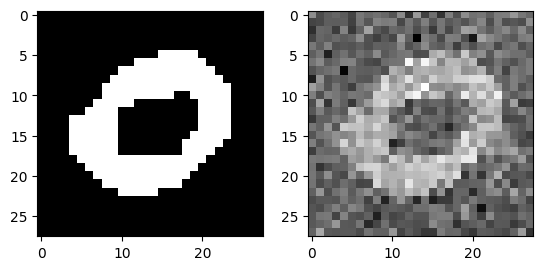

In [29]:
fig, ax = plt.subplots(1, 2)
j = 69
x, _ = train_set[j]
print(x.device)
ax[0].imshow(x.numpy()[0], cmap='gray')
ax[1].imshow(add_noise(x).numpy()[0], cmap='gray')

In [30]:
x.shape

torch.Size([1, 28, 28])

In [31]:
class ConvAE(nn.Module):
    def __init__(self, input_dim = 28, hidden_dim:int = 16, latent_dim:int = 32, kernel_size:int = 3):
        super(ConvAE, self).__init__()

        linear_dim = (hidden_dim//2) * (input_dim//4) * (input_dim//4)

        self.encoder = nn.Sequential(nn.Conv2d(1, hidden_dim, kernel_size=kernel_size, padding=1), # padding = 1 because of kernel = 3
                                     nn.GELU(), 
                                     nn.MaxPool2d(2, 2),
                                     nn.Conv2d(hidden_dim, int(hidden_dim/2), kernel_size=kernel_size, padding=1),
                                     nn.GELU(),
                                     nn.MaxPool2d(2, 2),
                                     nn.Flatten(),
                                     nn.Linear(linear_dim, latent_dim),
                                     nn.GELU()
                                     )
        
        self.decoder = nn.Sequential(nn.Linear(latent_dim, linear_dim),
                                     nn.GELU(), 
                                     nn.Unflatten(dim=1, unflattened_size=((hidden_dim//2), (input_dim//4), (input_dim//4))),
                                     nn.ConvTranspose2d(hidden_dim//2, hidden_dim, kernel_size=2, stride=2), 
                                     nn.ConvTranspose2d(hidden_dim, 1, kernel_size=2, stride=2), 
                                     nn.Sigmoid())

    def forward(self, x):
        x = self.encoder(x)

        return self.decoder(x)

epoch [1/51], tr_loss: 0.3049, val_loss: 0.2264
epoch [2/51], tr_loss: 0.1682, val_loss: 0.1592
epoch [3/51], tr_loss: 0.1322, val_loss: 0.1269
epoch [4/51], tr_loss: 0.1171, val_loss: 0.1115
epoch [5/51], tr_loss: 0.1095, val_loss: 0.1067
epoch [6/51], tr_loss: 0.1037, val_loss: 0.0953
epoch [7/51], tr_loss: 0.0993, val_loss: 0.0911
epoch [8/51], tr_loss: 0.0967, val_loss: 0.0882
epoch [9/51], tr_loss: 0.0937, val_loss: 0.0832
epoch [10/51], tr_loss: 0.0921, val_loss: 0.0841
epoch [11/51], tr_loss: 0.0892, val_loss: 0.0785
epoch [12/51], tr_loss: 0.0871, val_loss: 0.0766
epoch [13/51], tr_loss: 0.0865, val_loss: 0.0742
epoch [14/51], tr_loss: 0.0852, val_loss: 0.0738
epoch [15/51], tr_loss: 0.0827, val_loss: 0.0720
epoch [16/51], tr_loss: 0.0821, val_loss: 0.0703
epoch [17/51], tr_loss: 0.0810, val_loss: 0.0717
epoch [18/51], tr_loss: 0.0797, val_loss: 0.0678
epoch [19/51], tr_loss: 0.0787, val_loss: 0.0678
epoch [20/51], tr_loss: 0.0783, val_loss: 0.0674
epoch [21/51], tr_loss: 0.077

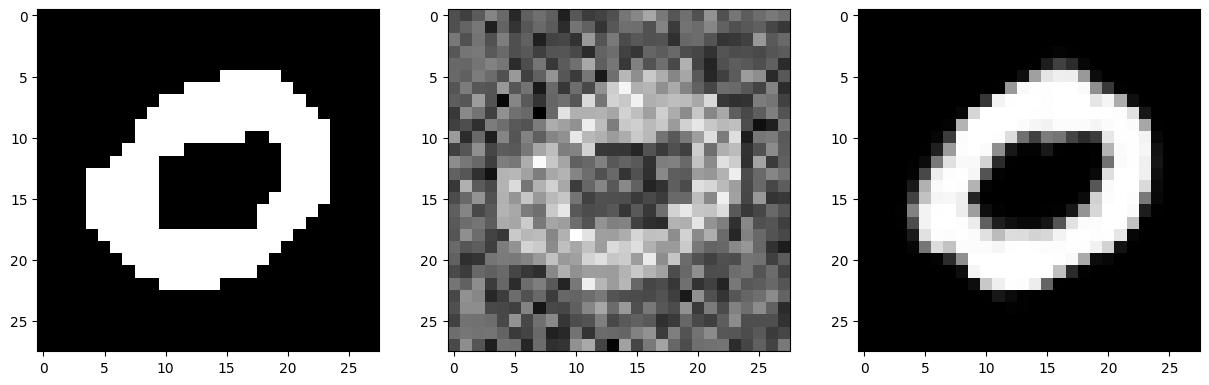

In [33]:
j = 69
fig, ax = plt.subplots(1, 3, figsize=(15, 15))
x, _ = train_set[j]
x_noisy = add_noise(x)
x_squeeze = x.unsqueeze(0)

model = ConvAE(hidden_dim=32, latent_dim=64).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=1e-4)
criterion = torch.nn.BCELoss()

train_loader = torch.utils.data.DataLoader(train_set, batch_size=1024, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=len(val_set), shuffle=False)

epochs = 51
for epoch in range(epochs):
    model.train()
    tr_epoch_loss = 0
    for i, (input_img, _) in enumerate(train_loader):
        optimizer.zero_grad()
        
        img_noisy = add_noise(input_img).to(device)
        out = model(img_noisy)
        
        
        input_img = input_img.to(device)
        tr_loss = criterion(out, input_img)

        tr_loss.backward()
        optimizer.step()
        
        tr_epoch_loss += tr_loss.item()


    model.eval()
    with torch.no_grad():
        for j, (input_img, _) in enumerate(val_loader):
            input_img = input_img.to(device)
            out = model(input_img)
                
            val_loss = criterion(out, input_img)

        print(f"epoch [{epoch + 1}/{epochs}], tr_loss: {tr_epoch_loss/(i+1):.4f}, val_loss: {val_loss.item():.4f}")
        
        if (epoch % 10 == 0):
            ax[0].imshow(x.numpy()[0], cmap='gray')
            ax[1].imshow(x_noisy.numpy()[0], cmap='gray')
            out = model(x_noisy.to(device).unsqueeze(0))
            ax[2].imshow(numpy.reshape((out.cpu().numpy()[0]), (28, 28)), cmap='gray')